In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as calculate_f1_score 
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
torch.set_printoptions(edgeitems=2, linewidth=75)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, time_steps):
        self.data = data
        self.targets = targets
        self.time_steps = time_steps
        self.total_windows = len(data) - time_steps

    def __len__(self):
        return self.total_windows # Provides last index for dataloader

    def __getitem__(self, idx): # Dataloader uses randomly shuffled idx 
        x = self.data[idx:idx + self.time_steps].flatten()
        y = self.targets[idx + self.time_steps - 1]
        return x, y

# Preprocess the data
file_path = r'/home/charlie51135/ml_final/dataset.csv'
dataframe = pd.read_csv(file_path)
# Check for null values
# print(dataframe.isnull().sum()*100/dataframe.shape[0])

# Convert 'Date' column to datetime and extract month and year
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe['Month'] = dataframe['Date'].dt.month
dataframe['Year'] = dataframe['Date'].dt.year
dataframe = dataframe.drop(columns=['Date'])

# Map 'Year' to a number representing the order
dataframe['Year'] = dataframe['Year'] - dataframe['Year'].min()

# Target variable 'SPX'
y = dataframe.pop('SPX').values

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), list(dataframe.columns))
    ])

# Apply the pipeline to the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_data = pipeline.fit_transform(dataframe)

# Convert to tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create dataset with 6-month time steps
dataset = TimeSeriesDataset(X_tensor, y_tensor, time_steps=6)

# Split training and test data
torch.manual_seed(123)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Print datasets 
# def print_dataset_samples(dataset, num_samples=5):
#     for i in range(num_samples):
#         x, y = dataset[i]
#         print(f"Sample {i}:")
#         print("Features (X):", x)
#         print("Target (Y):", y)
#         print("")

# # Print samples from the training dataset
# print("Training Dataset Samples:")
# print_dataset_samples(train_dataset)

# # Print samples from the validation dataset
# print("Validation Dataset Samples:")
# print_dataset_samples(val_dataset)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [4]:
# NN model class- no dropout or batch normalization
class FCNN_Base(nn.Module):
    def __init__(self, n_chans1, hid_layers, activation_function):
        super(FCNN_Base, self).__init__()
        self.hid_layers = hid_layers

        # First hidden layer
        self.layer1 = nn.Linear(360, n_chans1)

        # Conditional layers
        if hid_layers > 1:
            self.layer2 = nn.Linear(n_chans1, n_chans1 * 2)
        if hid_layers > 2:
            self.layer3 = nn.Linear(n_chans1 * 2, n_chans1 // 2)

        # Output layer
        if hid_layers == 1:
            self.layer4 = nn.Linear(n_chans1, 2)
        elif hid_layers == 2:
            self.layer4 = nn.Linear(n_chans1 * 2, 2)
        else:  # hid_layers == 3
            self.layer4 = nn.Linear(n_chans1 // 2, 2)
        
        self.activation = activation_function

    # Define forward path
    def forward(self, x):
        out = self.activation(self.layer1(x))
        if self.hid_layers > 1:
            out = self.activation(self.layer2(out))
        if self.hid_layers > 2:
            out = self.activation(self.layer3(out))
        out = self.layer4(out)
        return out

# NN model class with dropout and batch normalization
class FCNN(nn.Module):
    def __init__(self, n_chans1, hid_layers, activation_function, dropout_prob):
        super(FCNN, self).__init__()
        self.hid_layers = hid_layers

        # First hidden layer
        self.layer1 = nn.Linear(360, n_chans1)
        self.bn1 = nn.BatchNorm1d(n_chans1)
        self.dropout1 = nn.Dropout(dropout_prob)

        # Conditional layers
        if hid_layers > 1:
            self.layer2 = nn.Linear(n_chans1, n_chans1 * 2)
            self.bn2 = nn.BatchNorm1d(n_chans1 * 2)
            self.dropout2 = nn.Dropout(dropout_prob)
        if hid_layers > 2:
            self.layer3 = nn.Linear(n_chans1 * 2, n_chans1 // 2)
            self.bn3 = nn.BatchNorm1d(n_chans1 // 2)
            self.dropout3 = nn.Dropout(dropout_prob)

        # Output layer
        if hid_layers == 1:
            self.layer4 = nn.Linear(n_chans1, 2)
        elif hid_layers == 2:
            self.layer4 = nn.Linear(n_chans1 * 2, 2)
        else:  # hid_layers == 3
            self.layer4 = nn.Linear(n_chans1 // 2, 2)

        self.activation = activation_function

    # Define forward path
    def forward(self, x):
        out = self.dropout1(self.activation(self.bn1(self.layer1(x))))
        if self.hid_layers > 1:
            out = self.dropout2(self.activation(self.bn2(self.layer2(out))))
        if self.hid_layers > 2:
            out = self.dropout3(self.activation(self.bn3(self.layer3(out))))
        out = self.layer4(out)
        return out

# Validation function to calculate all metrics
def validate(model, train_loader, val_loader):
    model.eval()
    results = {
        "train": {"accuracy": 0, "f1_score": 0, "precision": 0, "recall": 0},
        "val": {"accuracy": 0, "f1_score": 0, "precision": 0, "recall": 0}
    }
    loaders = {"train": train_loader, "val": val_loader}

    for phase in ['train', 'val']:
        all_preds = []
        all_targets = []

        for X, y in loaders[phase]:
            X, y = X.to(device), y.to(device, non_blocking=True)

            with torch.no_grad():
                outputs = model(X)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        accuracy = accuracy_score(all_targets, all_preds)
        f1 = calculate_f1_score(all_targets, all_preds, average='binary')
        precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
        
        results[phase]["accuracy"] = accuracy
        results[phase]["f1_score"] = f1
        results[phase]["precision"] = precision
        results[phase]["recall"] = recall

    return results

# Training loop function
def training_loop(n_epochs, early_stop, train_updates, optimizer, model, loss_fn, train_loader, val_loader):
    best_score = 0.0
    epochs_without_improvement = 0
    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device, non_blocking=True)
            train_y_pred = model(X_batch)
            train_loss = loss_fn(train_y_pred, y_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        results = validate(model, train_loader, val_loader)

        # Optional print results per x epochs
        if epoch % 5 == 0 and train_updates == True:
            print(f"Epoch: {epoch}, Training Loss: {avg_train_loss:.6f}, "
                f"Training Accuracy: {results['train']['accuracy']:.4f}, "
                f"Validation Accuracy: {results['val']['accuracy']:.4f}")
            
        # Early stopping check using accuracy
        if early_stop == True:
            val_score = results['val']['accuracy']
            if val_score > best_score:
                best_score = val_score
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= 50:
                return results
    return results

# Hyperparameter search

In [46]:
# Define parameter space
learning_rate_options = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
optimizer_options = [optim.SGD, optim.Adam]
activation_options = [nn.ReLU(), nn.Tanh(), nn.LeakyReLU()]
n_chans1_options = [64, 128, 256, 512, 1024]
hid_layers_options = [1, 2, 3]
dropout_prob_options = [0.0, 0.5]

resultsList = []

# Exhaustive grid search
for lr in learning_rate_options:
    for optimizer_class in optimizer_options:
        for activation_function in activation_options:
            for n_chans1 in n_chans1_options:
                for hid_layers in hid_layers_options:
                    for dropout_prob in dropout_prob_options:
                        torch.manual_seed(123)

                        model = FCNN(n_chans1, 
                                     hid_layers, 
                                     activation_function, 
                                     dropout_prob
                                     ).to(device, non_blocking=True)
                        
                        optimizer = optimizer_class(model.parameters(), lr=lr)
                        loss_function = nn.CrossEntropyLoss()

                        results = training_loop(
                            n_epochs = 500,
                            early_stop = True,
                            train_updates = False,
                            optimizer = optimizer,
                            model = model,
                            loss_fn = loss_function,
                            train_loader = train_loader,
                            val_loader = val_loader)

                        # Add the results
                        val_results = results['val']
                        val_results['lr'] = lr
                        val_results['optimizer'] = optimizer_class.__name__
                        val_results['activation_function'] = type(activation_function).__name__
                        val_results['loss_function'] = type(loss_function).__name__
                        val_results['n_chans1'] = n_chans1
                        val_results['hid_layer'] = hid_layers
                        val_results['dropout_prob'] = dropout_prob
                        resultsList.append(val_results)

# Sort results by single metric
resultsList = sorted(resultsList, key=lambda x: x['precision'], reverse=True) 
for result in resultsList: 
    print(result)

{'accuracy': 0.4528301886792453, 'f1_score': 0.25641025641025644, 'precision': 1.0, 'recall': 0.14705882352941177, 'lr': 1, 'optimizer': 'Adam', 'activation_function': 'Tanh', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 128, 'hid_layer': 2, 'dropout_prob': 0.5}
{'accuracy': 0.4528301886792453, 'f1_score': 0.25641025641025644, 'precision': 1.0, 'recall': 0.14705882352941177, 'lr': 1e-05, 'optimizer': 'SGD', 'activation_function': 'ReLU', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 1024, 'hid_layer': 3, 'dropout_prob': 0.5}
{'accuracy': 0.6037735849056604, 'f1_score': 0.5882352941176471, 'precision': 0.8823529411764706, 'recall': 0.4411764705882353, 'lr': 1e-05, 'optimizer': 'SGD', 'activation_function': 'ReLU', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 64, 'hid_layer': 1, 'dropout_prob': 0.0}
{'accuracy': 0.6037735849056604, 'f1_score': 0.5882352941176471, 'precision': 0.8823529411764706, 'recall': 0.4411764705882353, 'lr': 1e-05, 'optimizer': 'SGD', 'activation_functio

In [47]:
# Sort results by single metric
resultsList = sorted(resultsList, key=lambda x: x['accuracy'], reverse=True) 
for result in resultsList: 
    print(result)

{'accuracy': 0.7169811320754716, 'f1_score': 0.7619047619047619, 'precision': 0.8275862068965517, 'recall': 0.7058823529411765, 'lr': 1e-05, 'optimizer': 'SGD', 'activation_function': 'Tanh', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 1024, 'hid_layer': 3, 'dropout_prob': 0.0}
{'accuracy': 0.6792452830188679, 'f1_score': 0.7536231884057971, 'precision': 0.7428571428571429, 'recall': 0.7647058823529411, 'lr': 1e-05, 'optimizer': 'Adam', 'activation_function': 'ReLU', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 64, 'hid_layer': 1, 'dropout_prob': 0.0}
{'accuracy': 0.6792452830188679, 'f1_score': 0.7536231884057971, 'precision': 0.7428571428571429, 'recall': 0.7647058823529411, 'lr': 1e-05, 'optimizer': 'Adam', 'activation_function': 'LeakyReLU', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 64, 'hid_layer': 1, 'dropout_prob': 0.0}
{'accuracy': 0.6792452830188679, 'f1_score': 0.7733333333333334, 'precision': 0.7073170731707317, 'recall': 0.8529411764705882, 'lr': 0.0001, 'op

# Results

3526146 [368640, 1024, 1024, 1024, 2097152, 2048, 2048, 2048, 1048576, 512, 512, 512, 1024, 2]

Learning Rate = 1e-05
Confusion matrix:
 [[14  5]
 [10 24]]
Validation Results - Accuracy: 0.7170, Precision: 0.8276, Recall: 0.7059, F1 Score: 0.7619


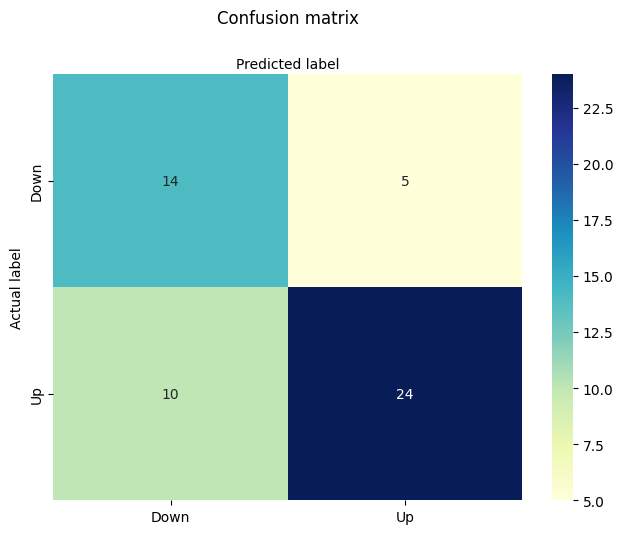

In [6]:
# Define parameters
learning_rates = [.00001]
optimizer_class = optim.SGD
activation_function = nn.Tanh()
loss_function = nn.CrossEntropyLoss()
n_chans1 = 1024
hid_layer = 3
dropout_prob = 0.0

for lr in learning_rates:
    torch.manual_seed(123)

    model = FCNN(n_chans1, 
                 hid_layer, 
                 activation_function, 
                 dropout_prob
                 ).to(device, non_blocking=True)
    
    numel_list = [p.numel() for p in model.parameters ()]
    print(sum(numel_list), numel_list)
    
    optimizer = optimizer_class(model.parameters(), lr=lr)

    results = training_loop(
        n_epochs = 500,
        early_stop = True,
        train_updates = False,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_function,
        train_loader = train_loader,
        val_loader = val_loader)
    
    # Get confusion matrix
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device, non_blocking=True)
            outputs = model(X_val_batch)

            _, predicted_classes = torch.max(outputs, 1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_targets.extend(y_val_batch.cpu().numpy())
    cnf_matrix = confusion_matrix(all_targets, all_preds)

    # Print results
    print("\nLearning Rate =", lr)
    print("Confusion matrix:\n", cnf_matrix)
    print(f"Validation Results - Accuracy: {results['val']['accuracy']:.4f}, "
        f"Precision: {results['val']['precision']:.4f}, "
        f"Recall: {results['val']['recall']:.4f}, "
        f"F1 Score: {results['val']['f1_score']:.4f}")

    # Confusion matrix using heatmap
    class_names = ['Down', 'Up']
    fig, ax = plt.subplots()
    # Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)